In [12]:
#para mostrar todos os resultados e não apenas o último
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"


In [284]:
import numpy as np
from numba import jit, jitclass, float64, njit
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
from quantecon.distributions import BetaBinomial

# Modelo de McCall Search 1

Primeiro modelo de mercado de trabalho
QuantEcon disse que é bom para aprender programação dinâmica

Lá vamos nós




$$
v^*(i)
= \max \left\{
        \frac{w(i)}{1 - \beta}, \, c + \beta \sum_{1 \leq j \leq n}
            v^*(j) q (j)
    \right\}
\quad
\text{for } i = 1, \ldots, n \tag{3}
$$

## Algoritmo

The Algorithm
To compute this vector, we use successive approximations:

Step 1: pick an arbitrary initial guess v∈Rn.

Step 2: compute a new vector$ v′∈Rn$ via

$v′(i)=max{w(i)1−β,c+β∑1≤j≤nv(j)q(j)}for i=1,…,n(4) $
Step 3: calculate a measure of the deviation between v and v′, such as$ maxi|v(i)−v′(i)|$.

Step 4: if the deviation is larger than some fixed tolerance, set v=v′ and go to step 2, else continue.

Step 5: return v.

Let {vk} denote the sequence genererated by this algorithm.

This sequence converges to the solution to (3) as k→∞, which is the value function v∗.

In [14]:
#parâmetros iniciais

n, a, b = 50, 200, 100                        # default parameters
q_default = BetaBinomial(n, a, b).pdf()       # distribuição Beta Binomial


In [17]:
#conjunto padrão de salários
w_min, w_max = 10, 60
w_default = np.linspace(w_min, w_max, n+1)

Text(0.5, 0, 'wages')

Text(0, 0.5, 'probabilities')

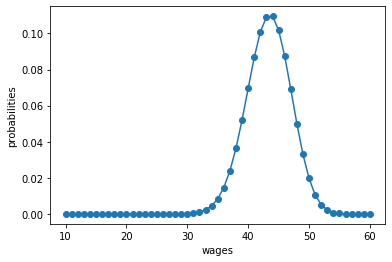

In [18]:
#gráfico
fig, ax = plt.subplots()
ax.plot(w_default, q_default, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

In [ ]:
β

In [19]:
#vamos descrever o tipo de dados que usaremos para facilitar a vida do Numba

mccall_data = [
    ('c', float64),      # unemployment compensation
    ('β', float64),      # discount factor
    ('w', float64[:]),   # array of wage values, w[i] = wage at state i
    ('q', float64[:])    # array of probabilities
]

$max value = max(w[i] / (1 - β), c + β * np.sum(v * q))$

In [20]:
#código

@jitclass(mccall_data)
class McCallModel:

    def __init__(self, c=25, β=0.99, w=w_default, q=q_default):

        self.c, self.β = c, β
        self.w, self.q = w_default, q_default
    def bellman(self, i, v):
        """
        The r.h.s. of the Bellman equation at state i.
        """
        # Simplify names
        c, β, w, q = self.c, self.β, self.w, self.q
        # Evaluate right hand side of Bellman equation
        max_value = max(w[i] / (1 - β), c + β * np.sum(v * q))
        return(max_value)

In [22]:
#função para plotar função valor

def plot_value_function_seq(mcm, ax, num_plots=6):
    """
    Plot a sequence of value functions.

        * mcm is an instance of McCallModel
        * ax is an axes object that implements a plot method.

    """

    n = len(mcm.w) #n é o tamanho de wages, testa uma vez para cada wage
    v = mcm.w / (1 - mcm.β) #v é o valor presente de aceitar a proposta atual
    v_next = np.empty_like(v)
    for i in range(num_plots):
        ax.plot(mcm.w, v, '-', alpha=0.4, label=f"iterate {i}")
        # Update guess
        for i in range(n):
            v_next[i] = mcm.bellman(i, v)
        v[:] = v_next  # copy contents into v

    ax.legend(loc='lower right')

Text(0.5, 0, 'wage')

Text(0, 0.5, 'value')

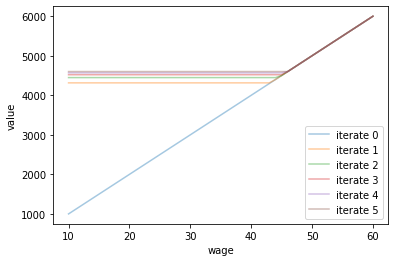

In [23]:
#rodando o modelo
mcm = McCallModel()

fig, ax = plt.subplots()
ax.set_xlabel('wage')
ax.set_ylabel('value')
plot_value_function_seq(mcm, ax)
plt.show()

In [24]:
#código para calcular salário de reserva


@jit(nopython=True)
def compute_reservation_wage(mcm,
                             max_iter=500,
                             tol=1e-6):

    # Simplify names
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q

    # == First compute the value function == #

    n = len(w)
    v = w / (1 - β)          # initial guess
    v_next = np.empty_like(v)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        for i in range(n):
            v_next[i] = mcm.bellman(i, v)

        error = np.max(np.abs(v_next - v))
        i += 1

        v[:] = v_next  # copy contents into v

    # == Now compute the reservation wage == #

    return (1 - β) * (c + β * np.sum(v * q))

#lembra bastante o código do gráfico
#principal diferença é que ele faz a norma do máximo entre o v_next e v



In [25]:
compute_reservation_wage(mcm)

47.316499710024964

## Estática Comparativa

Vejamos como o salário de reserva varia com beta e c



In [26]:
grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(10.0, 30.0, grid_size) #c varia de 10 a 30
β_vals = np.linspace(0.9, 0.99, grid_size)  #Beta varia de 0.9 a 0.99


#tem que fazer um enumerate para cada um
#como R é bidimensional, calculamos o salário para cada par [i,j] no grid

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        mcm = McCallModel(c=c, β=β)
        R[i, j] = compute_reservation_wage(mcm)


<a list of 7 text.Text objects>

Text(0.5, 1.0, 'reservation wage')

Text(0.5, 0, '$c$')

Text(0, 0.5, '$β$')

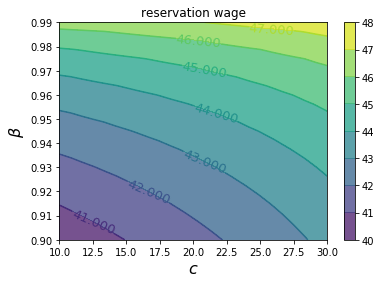

In [27]:
#gráfico
#esse negócio de contourf é novo para mim
fig, ax = plt.subplots()

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

## Exercício 1

Compute the average duration of unemployment when β=0.99 and c takes the following values

c_vals = np.linspace(10, 40, 25)

That is, start the agent off as unemployed, compute their reservation wage given the parameters, and then simulate to see how long it takes to accept.

Repeat a large number of times and take the average.

Plot mean unemployment duration as a function of c in c_vals.

In [28]:
@jit(nopython=True)
def compute_reservation_wage(mcm,
                             max_iter=500,
                             tol=1e-6):

    # Simplify names
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q

    # == First compute the value function == #

    n = len(w)
    v = w / (1 - β)          # initial guess
    v_next = np.empty_like(v)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        for i in range(n):
            v_next[i] = mcm.bellman(i, v)

        error = np.max(np.abs(v_next - v))
        i += 1

        v[:] = v_next  # copy contents into v

    # == Now compute the reservation wage == #

    return (1 - β) * (c + β * np.sum(v * q))

#lembra bastante o código do gráfico
#principal diferença é que ele faz a norma do máximo entre o v_next e v


In [216]:
#vou aproveitar parte do código anterior 

grid_size = 25
R = np.empty((grid_size, 1))

c_vals = np.linspace(10.0, 40.0, grid_size) #c varia de 10 a 40
β_vals = 0.99  #Beta fixo em 0.99


#tem que fazer um enumerate para cada um
#agora R voltou a ser unidimensional, logo o loop trabalha só em i

for i, c in enumerate(c_vals):
        mcm = McCallModel(c=c, β=β)
        R[i] = compute_reservation_wage(mcm)
        
#criei um salário de reserva para cada c. Agora vou calcular o tempo médio de stop para cada salário de reserva


In [217]:
R

len(R)

array([[46.45375475],
       [46.51657452],
       [46.57939429],
       [46.64221406],
       [46.70503383],
       [46.7678536 ],
       [46.83067336],
       [46.89349313],
       [46.95631291],
       [47.02917013],
       [47.12494666],
       [47.22072318],
       [47.31649971],
       [47.41227624],
       [47.50805277],
       [47.6038293 ],
       [47.69960583],
       [47.79538236],
       [47.89115889],
       [47.98693542],
       [48.1333602 ],
       [48.28778502],
       [48.44220984],
       [48.59663467],
       [48.75105949]])

25

In [292]:
#preciso criar uma função para a decisão ótima de parar

#o agente compara o salário atual ao salário de reserva em cada período
#aceita se o salário atual for maior ou igual ao salário de reserva

#função de distribuição acumulada
cdf = np.cumsum(q_default)


@jit
def stop_time(w_reserva, seed=1234):
    
    np.random.seed(seed)
    t = 1
    w_vals = []
    while True:
        w = w_default[qe.random.draw(np.cumsum(q_default))]
        if w >= w_reserva:
            stop = t
            w_vals.append(w)
            break
        else:
            t = t + 1
            w_vals.append(w)
    return stop
    



#função stop time tem agora o tempo ótimo de parada e também o histórico de ofertas de salário


#essa é a função para calcular valor de parada para um salário de reserva

#tem que deixar todas as funções no mesmo balaio



#shift + l mostra o número da linha


#quero calcular o tempo ótimo de parada mil vezes e calcular a média deles
@jit
def stop_time_mean(w_reserva, num_reps = 1_00_000):
    
    obs = np.empty(num_reps, dtype=np.float64)
    for i in range(num_reps):
        obs[i] = stop_time(w_reserva)
        
    return obs.mean()
    

    



#agora queremos calcular a média de tempo para várias retiradas da amostra, digamos 1_00_000


#para cada salário reserva, vou calcular a média de tempo de parada



In [312]:
#vou fazer um arranjo para guardar a média de tempo de stop em cada salário
    
stop_times = np.empty_like(c_vals)

for i in range(len(R)):
    stop_times[i] = stop_time_mean(R[i])

stop_times


array([ 5.26414,  5.22869,  5.22924,  5.25133,  5.25506,  5.26296,
        5.21077,  5.22385,  5.25592,  8.19388,  8.19706,  8.18261,
        8.14827,  8.19689,  8.21769,  8.23423,  8.22918,  8.24301,
        8.23753,  8.20562, 13.93382, 13.95804, 14.03141, 14.00141,
       13.99953])

array([10.  , 11.25, 12.5 , 13.75, 15.  , 16.25, 17.5 , 18.75, 20.  ,
       21.25, 22.5 , 23.75, 25.  , 26.25, 27.5 , 28.75, 30.  , 31.25,
       32.5 , 33.75, 35.  , 36.25, 37.5 , 38.75, 40.  ])

array([ 5.26414,  5.22869,  5.22924,  5.25133,  5.25506,  5.26296,
        5.21077,  5.22385,  5.25592,  8.19388,  8.19706,  8.18261,
        8.14827,  8.19689,  8.21769,  8.23423,  8.22918,  8.24301,
        8.23753,  8.20562, 13.93382, 13.95804, 14.03141, 14.00141,
       13.99953])

[Text(0, 0.5, 'months'), Text(0.5, 0, 'unemployment compensation')]

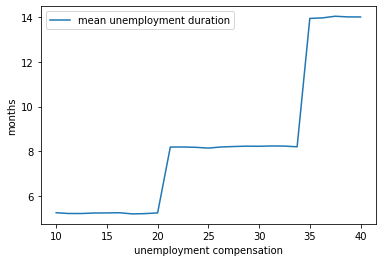

In [313]:
#criando gráfico

c_vals
stop_times


fig, ax = plt.subplots()
ax.plot(c_vals, stop_times, label ="mean unemployment duration")
ax.set(xlabel="unemployment compensation", ylabel = "months")
ax.legend()

plt.show()

Rascunhos do exercício 1

In [269]:
R.dtype

dtype('float64')

In [274]:
#esse bloco funciona
n = 1_000_000

obs = np.empty(n)
for i in range(n):
    obs[i] = stop_time(R[0])

obs.mean()

5.230883

In [33]:
#gabarito 



cdf = np.cumsum(q_default)

@jit(nopython=True)
def compute_stopping_time(w_bar, seed=1234):

    np.random.seed(seed)
    t = 1
    while True:
        # Generate a wage draw
        w = w_default[qe.random.draw(cdf)]
        # Stop when the draw is above the reservation wage
        if w >= w_bar:
            stopping_time = t
            break
        else:
            t += 1
    return stopping_time


@jit(nopython=True)
def compute_mean_stopping_time(w_bar, num_reps=100000):
    obs = np.empty(num_reps)
    for i in range(num_reps):
        obs[i] = compute_stopping_time(w_bar, seed=i)
    return obs.mean()






In [34]:
compute_mean_stopping_time(40)

1.16752

In [ ]:
stop_time_mean(46)

[Text(0, 0.5, 'months'), Text(0.5, 0, 'unemployment compensation')]

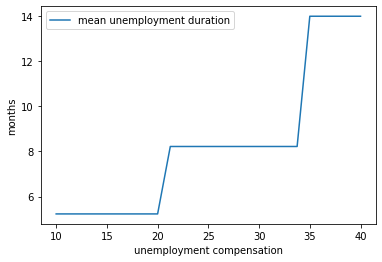

In [35]:
#agora é um loop para calcular a média de tempo em cada caso

#RETOMAR DAQUI

c_vals = np.linspace(10, 40, 25)
stop_times = np.empty_like(c_vals)
for i, c in enumerate(c_vals):
    mcm = McCallModel(c=c)
    w_bar = compute_reservation_wage(mcm)
    stop_times[i] = compute_mean_stopping_time(w_bar)

fig, ax = plt.subplots()

ax.plot(c_vals, stop_times, label="mean unemployment duration")
ax.set(xlabel="unemployment compensation", ylabel="months")
ax.legend()

plt.show()

In [ ]:
b_valores = np.linspace(0.9, 0.99, 25)
b_valores

enumerar = enumerate(b_valores)
enumerar

## Exercício 2

The purpose of this exercise is to show how to replace the discrete wage offer distribution used above with a continuous distribution.

This is a significant topic because many convenient distributions are continuous (i.e., have a density).

Fortunately, the theory changes little in our simple model.

Recall that h in (6) denotes the value of not accepting a job in this period but then behaving optimally in all subsequent periods:

To shift to a continuous offer distribution, we can replace (6) by

$h=c+β∫v∗(s′)q(s′)ds′$.(9)
Equation (7) becomes

$h=c+β∫max{w(s′)1−β,h}q(s′)ds′$(10)
The aim is to solve this nonlinear equation by iteration, and from it obtain the reservation wage.

Try to carry this out, setting

the state sequence {st} to be IID and standard normal and
the wage function to be $w(s)=exp(μ+σs)$.
You will need to implement a new version of the McCallModel class that assumes a lognormal wage distribution.

Calculate the integral by Monte Carlo, by averaging over a large number of wage draws.

For default parameters, use c=25, β=0.99, σ=0.5, μ=2.5.

Once your code is working, investigate how the reservation wage changes with c and β.

In [326]:
#primeiro vou olhar essa fórmula do h

@jit(nopython=True)
def compute_reservation_wage_two(mcm,
                                 max_iter=500,
                                 tol=1e-5):

    # Simplify names
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q

    # == First compute h == #

    h = np.sum(w * q) / (1 - β)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        s = np.maximum(w / (1 - β), h)
        h_next = c + β * np.sum(s * q)

        error = np.abs(h_next - h)
        i += 1

        h = h_next

    # == Now compute the reservation wage == #

    return (1 - β) * h



In [327]:
#testando a função
mcm = McCallModel()
compute_reservation_wage_two(mcm)

47.316499166392944

Passo 1: Criando nova classe de McCall Model que funciona com wage lognormal

For default parameters, use c=25, β=0.99, σ=0.5, μ=2.5.

Repare que o modelo usa como argumentos o tipo de dados. Vamos ajustar isso primeiro

In [328]:
mccontinuous_data = [
    ('c', float64),      # unemployment compensation
    ('β', float64),      # discount factor
    ('w', float64[:]),   # array of wage values, w[i] = wage at state i
    ('q', float64[:]),    # array of probabilities
    ('σ', float64),       #desvio-padrão
    ('μ', float64)        #média da distribuição lognormal
]

In [413]:
#definindo w_lognormal no lugar de w_default


n, a, b = 50, 200, 100                        # default parameters
q_lognormal = np.random.randn(1000)  




w_lognormal = np.random.lognormal(mean = 2.5, sigma = 0.5, size =  1000)


w_lognormal

draws = np.exp(2.5 + 0.5 * q_lognormal)
draws




#conjunto padrão de salários
# w_min, w_max = 10, 60
# w_default = np.linspace(w_min, w_max, n+1)

array([ 9.82392305, 10.72589557, 11.31242791,  6.91992137, 19.93292642,
       10.60120669,  8.11272905,  5.88854419,  8.07762339, 11.41439545,
        3.63113109, 12.62817735, 13.33076272, 13.03598411,  9.01434536,
        6.32094457, 16.55188342,  5.19171179, 10.52928696,  6.24056099,
       25.45987012, 27.66232073,  8.61809723,  9.61488796, 21.36099597,
        9.09781487, 18.49425632,  8.77349688, 22.58546722,  8.00608376,
       10.5423989 , 27.10214202, 16.5315558 , 21.82093251, 16.56928125,
       15.94155358,  8.3164195 , 13.2415304 , 14.14472308, 28.5812276 ,
        8.01950857, 18.37513263,  5.41507497, 18.84859391, 12.52326192,
       22.92786166, 10.35472728, 12.60836691, 14.94494861,  6.9095791 ,
       18.87344251,  8.9691456 , 15.07992747,  5.26105228, 32.73614607,
        8.37897919, 25.58640565, 11.5775579 ,  4.46945109,  4.85654673,
       14.29111675, 14.71255005,  6.28711576,  9.65922232, 18.9009413 ,
        7.54372973,  4.86529745, 12.74145457, 17.08560365,  5.35

array([ 6.80540448, 18.89346467, 14.53278475,  9.52683428, 19.09002224,
        5.76083027, 16.13577162,  6.60638481,  3.89537835, 15.52917212,
       15.18418499,  7.0617002 , 14.41786108,  6.24624377, 12.4568171 ,
       12.39798403, 17.01099782,  8.97703659, 13.15221195,  8.54904459,
       15.676896  , 13.56170535,  9.62736211,  5.63629398, 12.71036091,
       11.96239986, 32.56379242, 10.84605513,  8.21052489,  8.067962  ,
        4.84940519,  7.08151332, 19.48491056, 11.09223011, 20.17917191,
        9.82713409, 23.87869157,  9.87854683, 11.50865023,  7.01110651,
       10.91013256, 17.19721125, 14.63407958,  6.00951273, 13.46327676,
       32.74536568, 12.55108219, 10.0432171 , 28.97174602, 11.27821567,
       15.42914279,  7.74474686,  8.4120523 , 21.04800243, 10.4279255 ,
       11.00229216, 10.21845119, 12.80096804, 15.87340434, 17.26545922,
        9.53984107, 16.94436833, 11.74117776,  7.96899693,  8.61154939,
       19.77494949, 18.63787921,  6.84951684, 15.00713124,  8.19

In [414]:
#conferindo se a média dos dois salários fica parecida

np.mean(w_lognormal)

np.mean(draws)

#fica sim

13.34021388368905

13.852286877237084

In [419]:
@jitclass(mccontinuous_data)
class McContinuous:

    def __init__(self, c=25, β=0.99, σ = 0.5, μ = 2.5,  w=w_default, q=q_default):

        self.c, self.β = c, β
        self.σ, self.μ = σ, μ
        
        
        self.w, self.q = w_lognormal, q_default
    def w_reserva(self, max_iter=500, tol=1e-5):
        """
        o salário reserva no caso contínuo
        
        o valor de continuar v(s) é uma média ponderada dos salários possíveis
        pelas probabilidades de consegui-los
        """
        # Simplify names - agora com complementos
        c, β, w, q = self.c, self.β, self.w, self.q
        σ, μ = self.σ, self.μ
        
        
        #chute inicial para h
        h = np.mean(w) / (1-β)
        i = 0
        error = tol + 1
        
        
        while i < max_iter and error > tol:
                   
            arg_max = np.maximum( w/(1-β), h) #argumento da integral
            integral = np.mean(arg_max)
        
            h_next = c +   β * integral 
        
            error = np.abs(h_next - h) #diferença entre h atual e próximo
        
            i = i + 1
        
            h = h_next
        
        return (1-β) * h
    



In [435]:
mcmc = McContinuous()
mcmc.w_reserva()

32.09567084997061

In [437]:
#investiguemos como o salário varia com os parâmetros

grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(10.0, 30.0, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        mcmc = McContinuous(c=c, β=β)
        R[i, j] = mcmc.w_reserva()

<a list of 7 text.Text objects>

Text(0.5, 1.0, 'reservation wage')

Text(0.5, 0, '$c$')

Text(0, 0.5, '$β$')

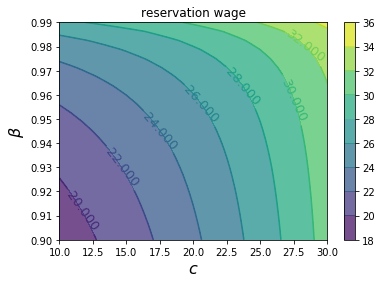

In [439]:
fig, ax = plt.subplots()

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

Meus exercícios estão um pouco diferentes do gabarito


Acho que estão corretos

A parte que está um pouco duvidosa é a njit no exercício 1, parece que ele não está otimizando